# AirBnb listings file modeling

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import seaborn as sns
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsGeoViz import *
from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [3]:
data_path = os.path.join(os.getcwd(), "../data/cleaned_listings.csv")
listings = pd.read_csv(data_path, index_col="id")
display(listings.shape)

(48855, 80)

### Plot the dstribution

Let's plot the percentile for price

Text(0, 0.5, 'Price')

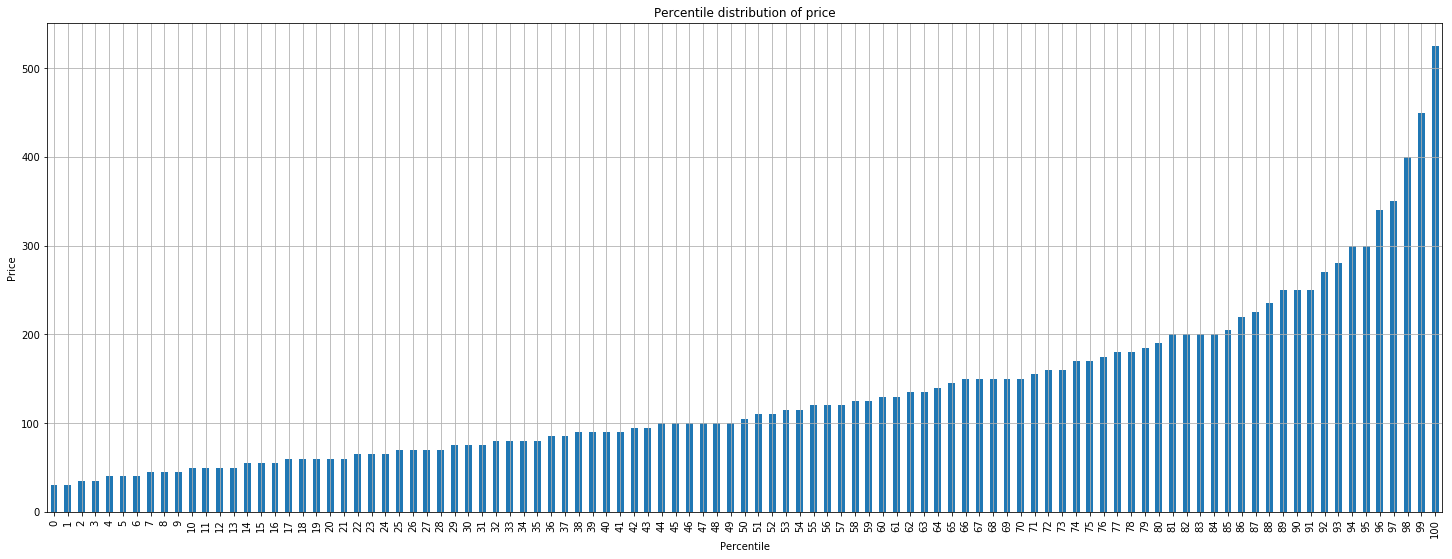

In [4]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(25,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

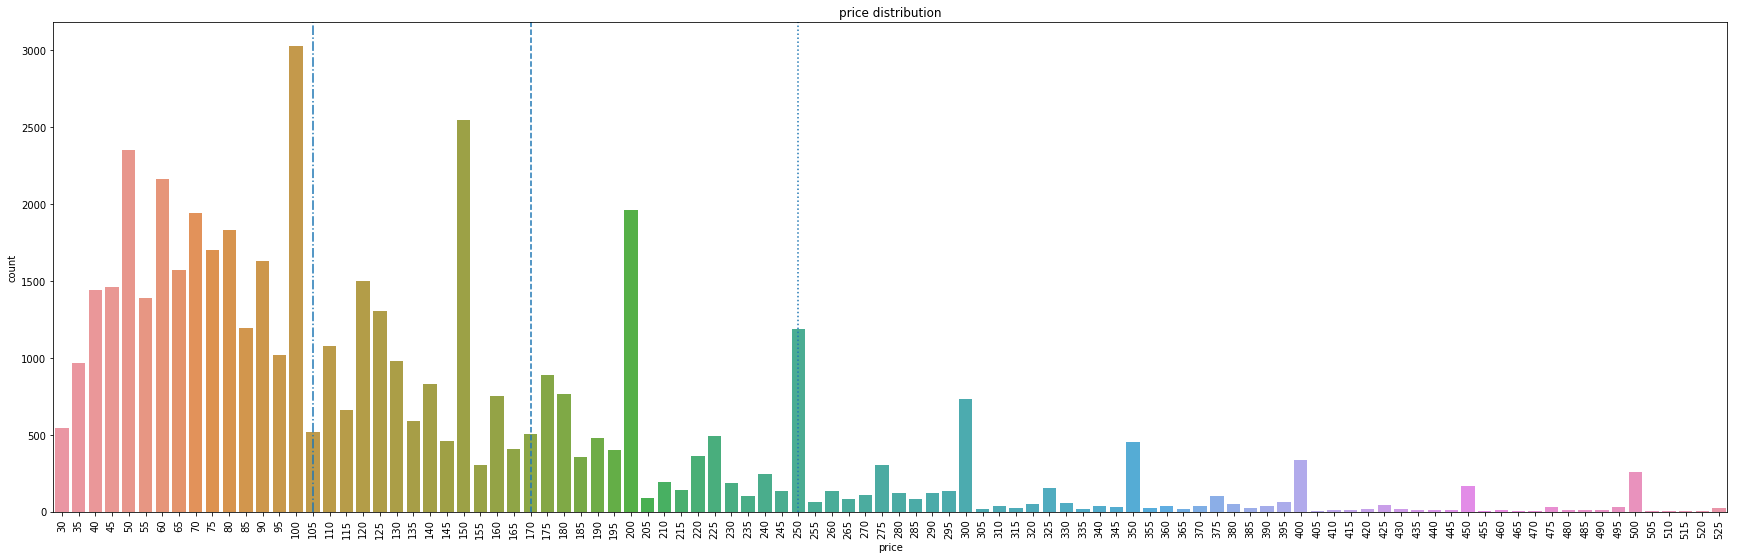

In [5]:
f, ax = plt.subplots(1,1,figsize=(30,9))
g = sns.countplot(x="price", data=listings, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")
median_idx = np.where(np.sort(listings["price"].unique())==listings["price"].median())
plt.axvline(x=median_idx, linestyle="-.")
percentile_75_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[75,:].values[0])
plt.axvline(x=percentile_75_idx, linestyle="--")
percentile_90_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[90,:].values[0])
plt.axvline(x=percentile_90_idx, linestyle=":")

------------------

Quick helper functions

In [6]:
def roundto(row, base=5):
    return int(base * round(float(row) / base))

# Synthetic sample generation

### 1. Train test split

In [7]:
train, test = train_test_split(listings, test_size=0.2, random_state=RANDOM_SEED)

### 2. Oversampling using SMOTE

In [8]:
def check_rep(row):
    if (row <= 200) | (row==250) | (row==350) | (row==450) | (row==550) :
        return 0
    elif (row > 200) & (row < 300) & (row != 250):
        return 1 
    elif (row > 300) & (row < 400) & (row != 350):
        return 2 
    else:
        return 3 

train["flag_ur"] = train["price"].apply(check_rep)

In [9]:
vcs = train["flag_ur"].value_counts()
vcs

0    34674
1     2455
3     1313
2      642
Name: flag_ur, dtype: int64

In [10]:
ycol = ["flag_ur"]
xcol = [i for i in train.columns if i not in ycol]

x = train[xcol].values
y = train[ycol].values

smote_sampling_strategy = {
#     1: int(vcs[1]*2),
    2: int(vcs[2]*3)
    ,3: int(vcs[3]*3)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)

x_new, y_new = sm.fit_sample(x, y)

# Drop the flag column
train.drop(labels=["flag_ur"], axis=1, inplace=True)

# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

price_index = get_index(list(train.columns), "price")

y = x_new[:, price_index]
x_train = np.delete(x_new, price_index, axis=1)

y_new = []
for elem in y:
    y_new.append(roundto(elem))

y_train = y_new

d:\softwares\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
print(
"New size :", x_train.shape, "\n",
"Old size :", train.shape,
)

New size : (42994, 79) 
 Old size : (39084, 80)


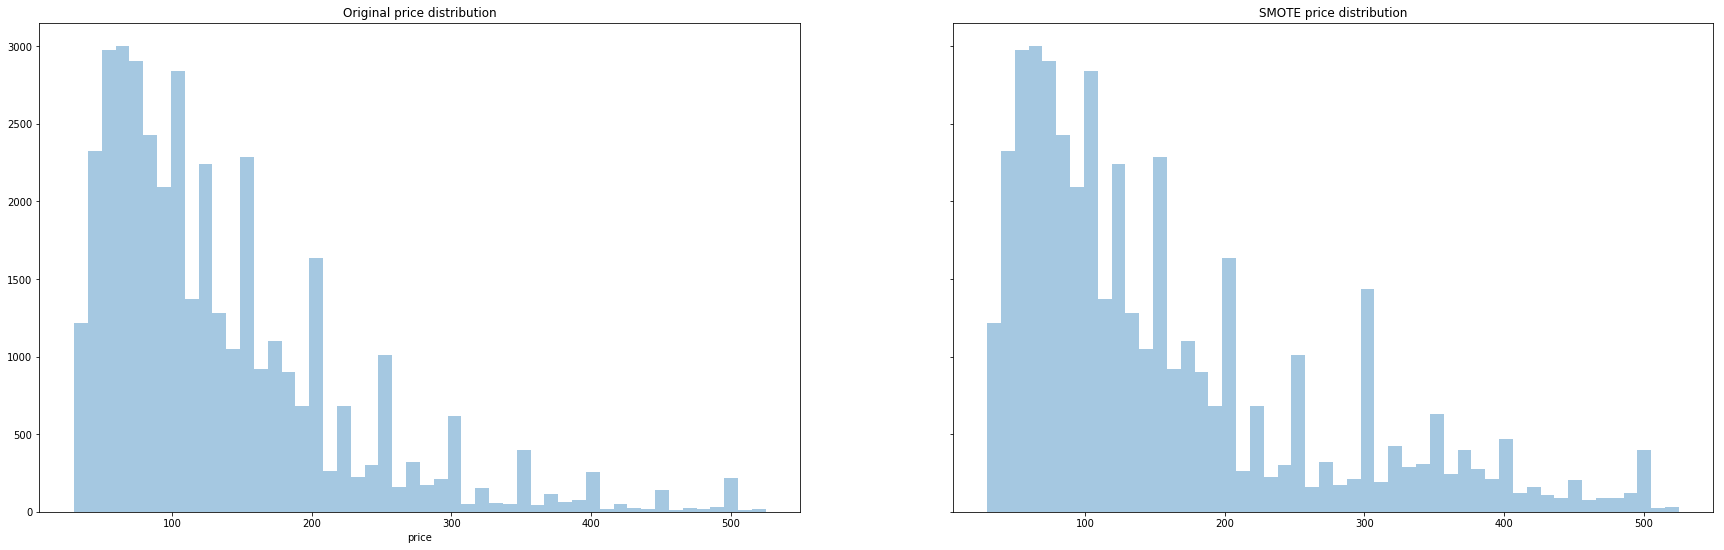

In [12]:
f, ax = plt.subplots(1, 2, figsize=(30, 9), sharey=True)
g1 = sns.distplot(train["price"], ax=ax[0], kde=False)
t = g1.set_title("Original price distribution")

g2 = sns.distplot(y, ax=ax[1], kde=False)
t = g2.set_title("SMOTE price distribution")


### 3. Standardisation

In [13]:
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)

In [14]:
# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

price_index = get_index(list(test.columns), "price")

x_tmp = test.values
y_test = x_tmp[:, price_index]
x_test = np.delete(x_tmp, price_index, axis=1)

y_tmp = []
for elem in y_test:
    y_tmp.append(roundto(elem))

y_test = y_tmp

x_test = standard_scaler.transform(x_test)

### 4. Transformation

d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


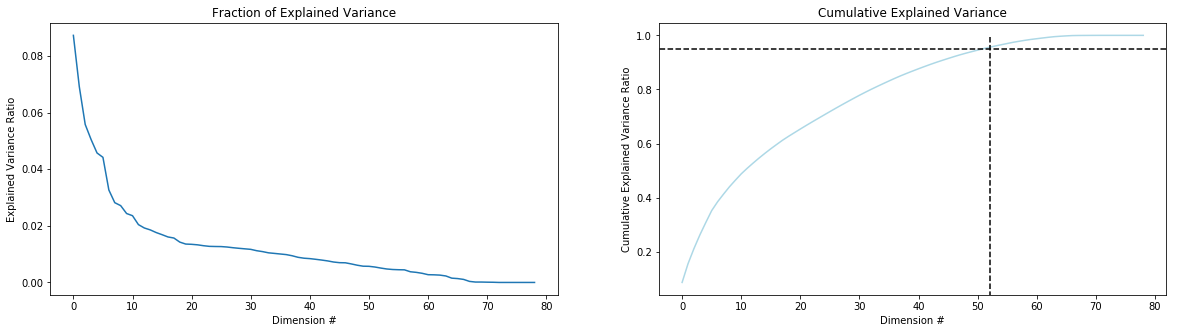

In [15]:
pca_naive = PCA(n_components=None)
pca_naive.fit(x_train)
f, ax = plt.subplots(1,2,figsize=(20,5))
plot_naive_variance(pca_naive, ax[0])
num_pc = plot_pca_var_cum(pca_naive, ax=ax[1], cutoff=0.95)

In [16]:
# pca = PCA(n_components=num_pc)
pca = PCA(n_components=None)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

## Prediction

### Random Forest Regressor

#### With PCA

In [37]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train_pca, y=y_train)
y_pred_train = rfr.predict(X=x_train_pca)
y_pred_test = rfr.predict(X=x_test_pca)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 27.26
Test set RMSE: 60.65


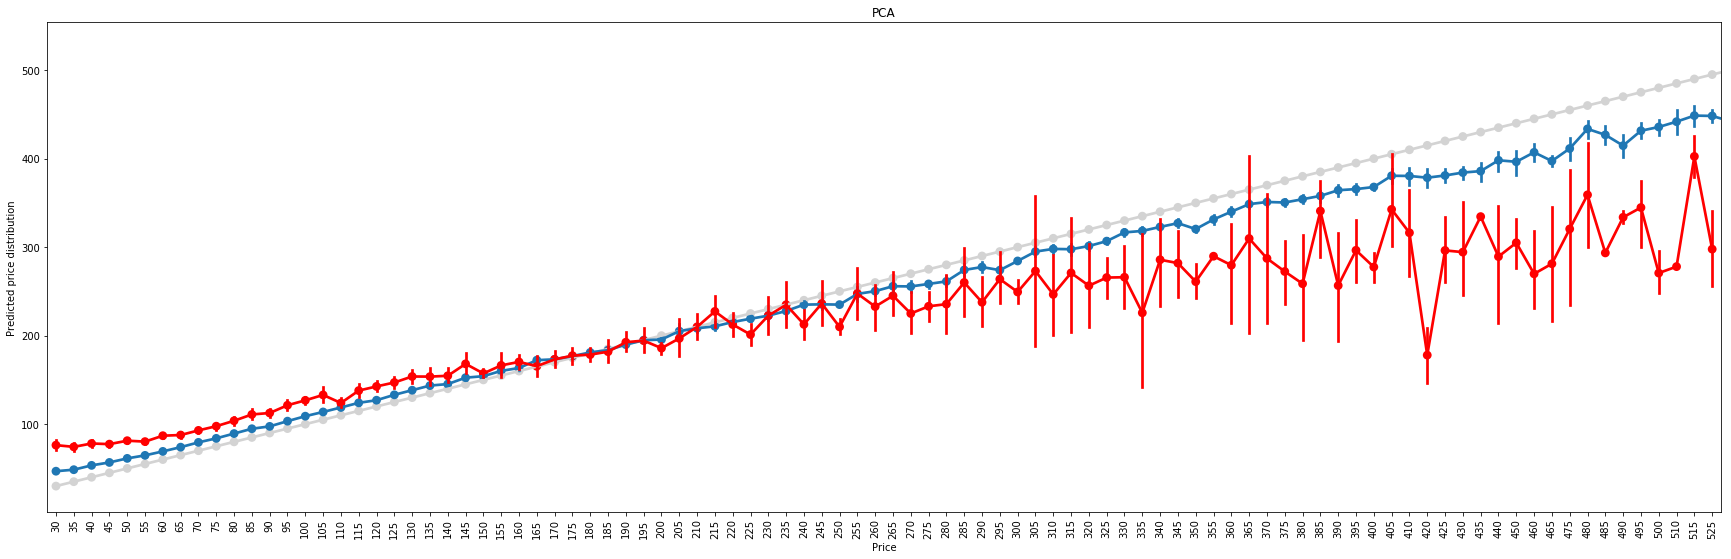

In [38]:
f, ax = plt.subplots(1,1, figsize=(30, 9))
g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("PCA")

In [19]:
rfr = RandomForestRegressor()
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE: {:.2f}".format(rmse_train))
print("Test set RMSE: {:.2f}".format(rmse_test))

Train set RMSE: 23.81
Test set RMSE: 54.83


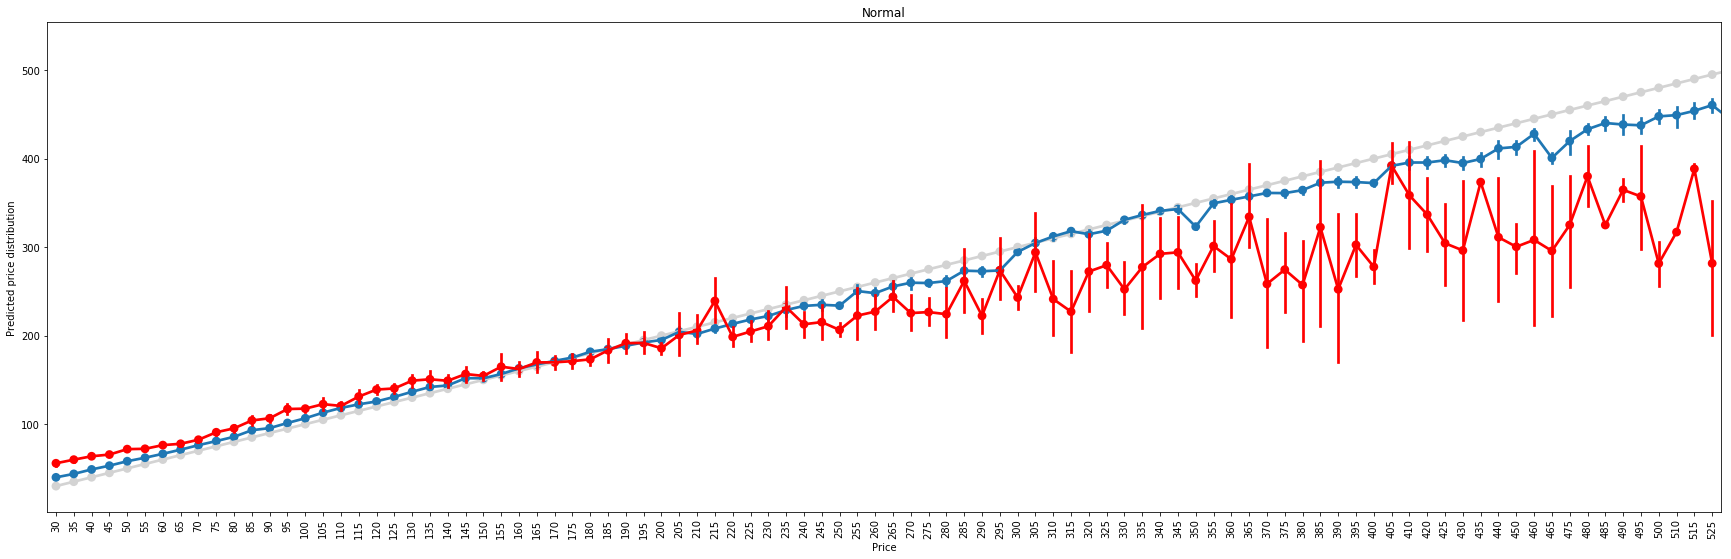

In [36]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=np.unique(y_train), y=np.unique(y_train), color="lightgrey", ax=ax, linestyle="--")
g = sns.pointplot(x=y_train, y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test, y=y_pred_test, ax=ax, color="red")

t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Normal")